In [6]:
from InterOptimus.itworker import InterfaceWorker
from pymatgen.core.structure import Structure
from mp_api.client import MPRester

In [7]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

In [8]:
with MPRester('fFtrdShVJH4jwWHiId8v4cyGzV2oYnoG') as mpr:
        docs = mpr.materials.summary.search(
        material_ids = ["mp-1097036", "mp-51"],
        fields=["material_id", "structure", "nelements"])
        for doc in docs:
            material_id = doc.material_id
            structure = doc.structure
    
            # 使用 SpacegroupAnalyzer 获取常规结构
            analyzer = SpacegroupAnalyzer(structure)
            doc.structure = analyzer.get_conventional_standard_structure()
for i in docs:
    if i.material_id == "mp-1097036":
        film_conv = i.structure
    else:
        substrate_conv = i.structure
iw = InterfaceWorker(film_conv, substrate_conv)

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
film_conv.reduced_formula

'Li3PS4'

In [10]:
substrate_conv.reduced_formula

'Li'

In [11]:
iw.lattice_matching(max_area = 82, max_length_tol = 0.05, max_angle_tol = 0.05,
                    film_max_miller = 4, substrate_max_miller = 4, film_millers = None, substrate_millers = None)
#Note max millers are in primitive cell, should be different from the indices in the polar projection below which are in conventional cell
#If you specify miller indices yourself, just ignore film_max_miller and substrate_max_miller

3


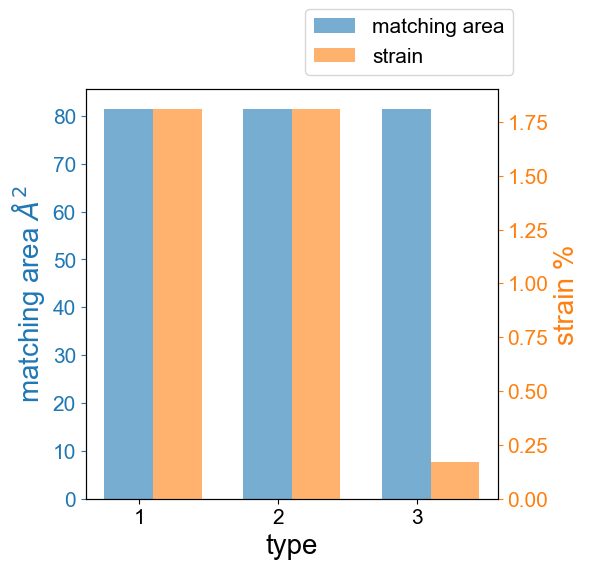

In [12]:
#Visualize matching information
iw.ems.plot_unique_matches() 

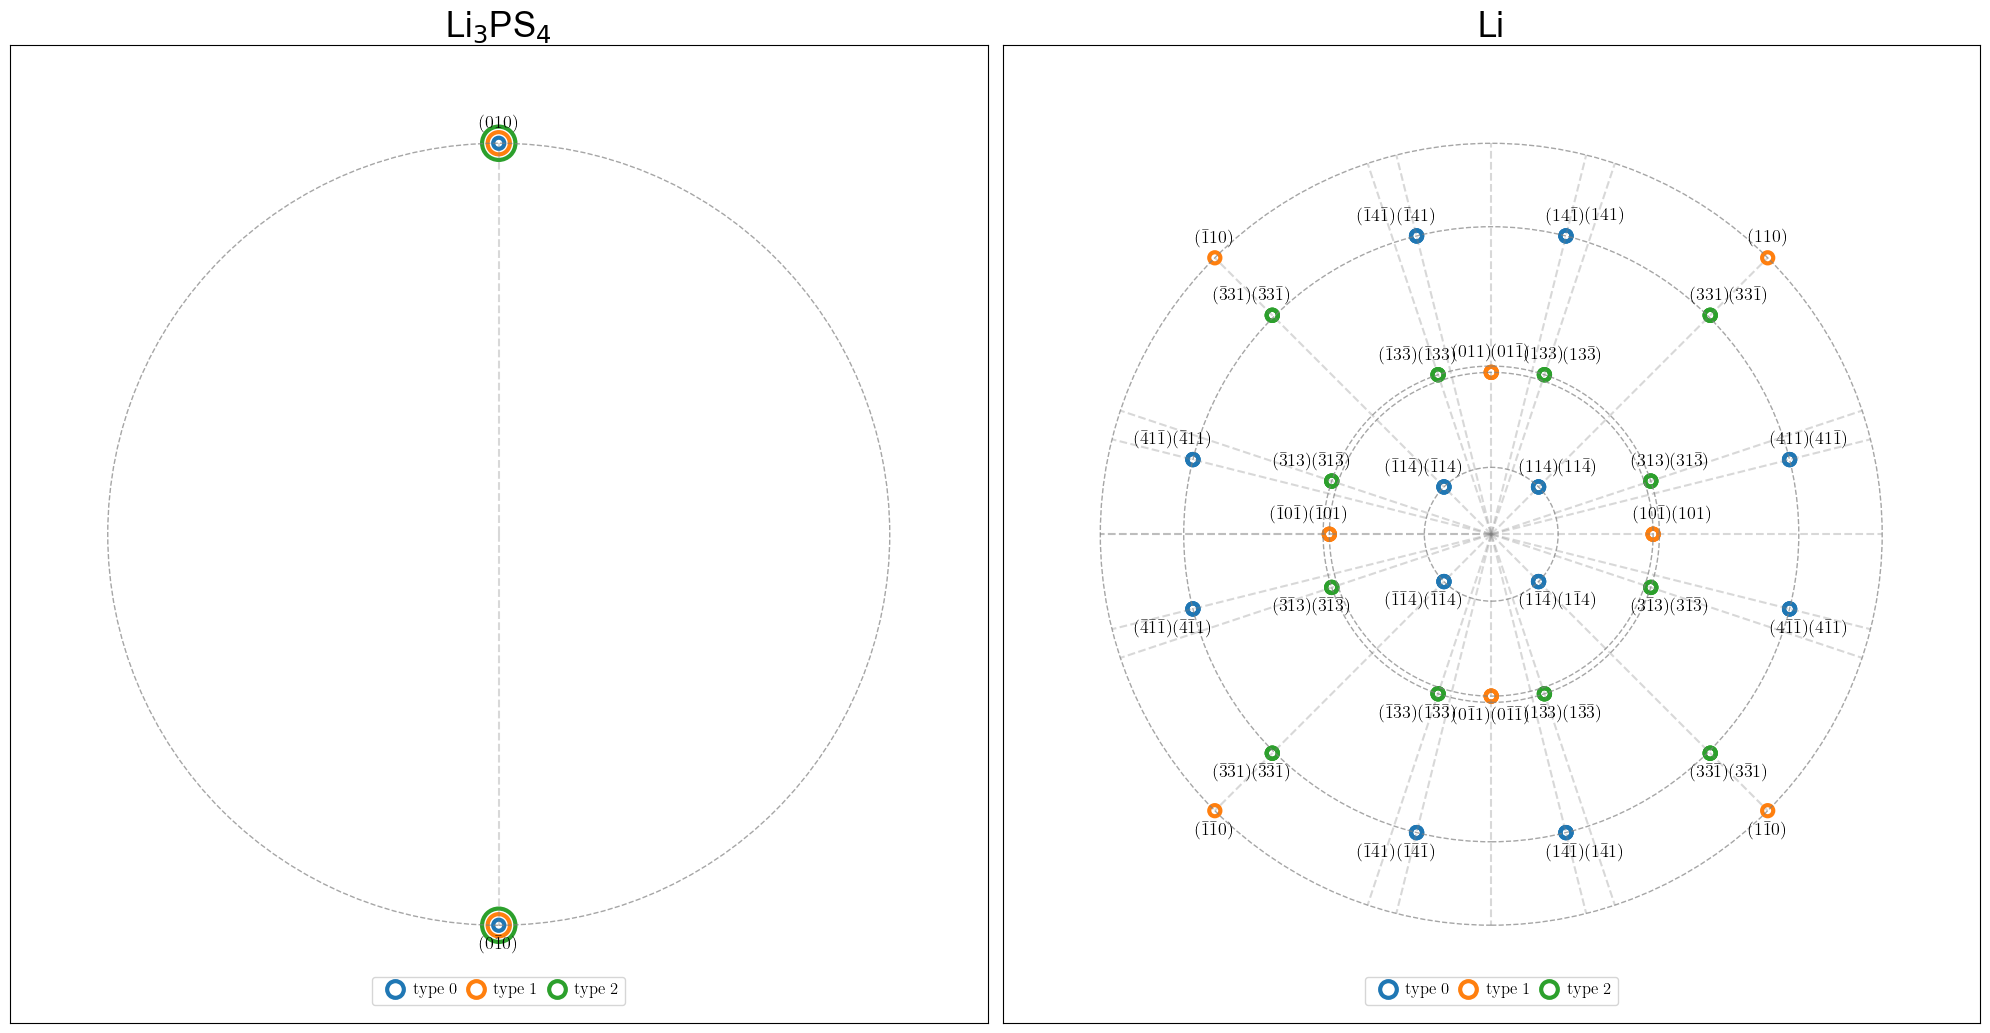

In [13]:
iw.ems.plot_matching_data(['Li$_3$PS$_4$', 'Li'],'project.jpg', show_millers = True, show_legend = True)

In [14]:
iw.parse_interface_structure_params(termination_ftol = 0.3, c_periodic = False, \
                                    vacuum_over_film = 8, film_thickness = 8, \
                                    substrate_thickness = 8, shift_to_bottom = True)

symmetry checking progress: 100%:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

In [15]:
wf = iw.global_random_sampling(n_taget = 5, 
                               n_max = 1000, sampling_min_displace = 1, discut = 1,
                               to_fireworks = True,
                              project_name = 'Li_Li3PS4', 
                                db_file = '/public5/home/t6s001944/.conda/envs/general/lib/python3.12/site-packages/atomate/config/db.json',
                                vasp_cmd = 'mpirun -np 96 vasp_std',
                                user_incar_settings={'NCORE':12}, 
                               work_dir = '/public5/home/t6s001944/InterOptimusPaper/random_sampling/Li_Li3PS4/vasp')

matches:   0%|          | 0/3 [00:00<?, ?it/s]

unique terminations:   0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/envs/3.12/lib/python3.12/site-packages/pymatgen/io/vasp/sets.py:276: BadInputSetWarning: Overriding the POTCAR functional is generally not recommended  as it significantly affects the results of calculations and compatibility with other calculations done with the same input set. Note that some POTCAR symbols specified in the configuration file may not be available in the selected functional.
  warnings.warn(


unique terminations:   0%|          | 0/4 [00:00<?, ?it/s]

unique terminations:   0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
import pickle
with open('wf.pkl','wb') as f:
    pickle.dump(wf.to_dict(), f)

In [1]:
import json

In [152]:
with open('global_random_sampling_dft_False.json', 'r') as f:
    data = json.load(f)

In [141]:
from numpy import *

In [153]:
dft_results = {}
predict_results = {}
for mlip in ['chgnet', 'mace', 'orb-models', 'sevenn']:
    dft_results[mlip] = {}
    predict_results[mlip] = {}
    dft_results[mlip]['sup_Es'] = []
    dft_results[mlip]['it_Es'] = []
    dft_results[mlip]['bd_Es'] = []
    dft_results[mlip]['slab_Es'] = []
    
    predict_results[mlip]['sup_Es'] = []
    predict_results[mlip]['it_Es'] = []
    predict_results[mlip]['bd_Es'] = []
    predict_results[mlip]['slab_Es'] = []
    
    for i in iw.global_random_sample_dict.keys():
        atom_num = len(Structure.from_dict(json.loads(iw.global_random_sample_dict[i]['sampled_interfaces'][0])))
        dft_results[mlip]['sup_Es'] += list(array(data[i]['DFT_results']['xyz_Es'])/atom_num)
        
        predict_results[mlip]['sup_Es'] += list(array(iw.global_random_sample_dict[i]['predict'][mlip]['sup_Es'])/atom_num)
        
        dft_results[mlip]['it_Es'] += data[i]['DFT_results']['it_Es']
        predict_results[mlip]['it_Es'] += iw.global_random_sample_dict[i]['predict'][mlip]['it_Es']

        dft_results[mlip]['bd_Es'] += data[i]['DFT_results']['bd_Es']
        predict_results[mlip]['bd_Es'] += iw.global_random_sample_dict[i]['predict'][mlip]['bd_Es']

In [154]:
import matplotlib.pyplot as plt

In [155]:
def draw(e,title):
    #sup_Es
    all_dfts = []
    all_predicts = []
    plt.figure(figsize = (5,5))
    count = 0
    for mlip in ['chgnet', 'mace', 'orb-models', 'sevenn']:
        dft_data = array(dft_results[mlip][e])
        predict_data = array(predict_results[mlip][e])

        zero_ids = where(dft_data == 0)[0]
        non_zero_ids = where(dft_data != 0)[0]
        
        non_zero_dft = dft_data[non_zero_ids]
        zero_dft = dft_data[zero_ids]
        non_zero_predict = predict_data[non_zero_ids]
        zero_predict = predict_data[zero_ids]
        all_dfts+=list(non_zero_dft)
        all_predicts+=list(non_zero_predict)
        plt.scatter(zero_predict, zero_predict, alpha = 0.4, s =200, marker = 's', c = f'C{count}')
        plt.scatter(non_zero_predict, non_zero_dft, alpha = 0.4, s =400, label = mlip, marker = 'o', c = f'C{count}')
        count += 1
    plt.axis('equal')
    plt.xlabel('predicted E eV/atom', fontsize = 25)
    plt.ylabel('dft E eV/atom', fontsize = 25)
    plt.plot([-100,100],[-100,100], c = 'k')
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlim(min(min(all_dfts), min(all_predicts))-0.1, max(max(all_dfts), max(all_predicts)) +0.1)
    plt.ylim( min(min(all_dfts), min(all_predicts))-0.1, max(max(all_dfts), max(all_predicts)) +0.1)
    plt.title(title, fontsize = 20)
    plt.legend(fontsize = 15)
    plt.tight_layout()
    plt.savefig(f'{title}.jpg',dpi=600,format ='jpg')

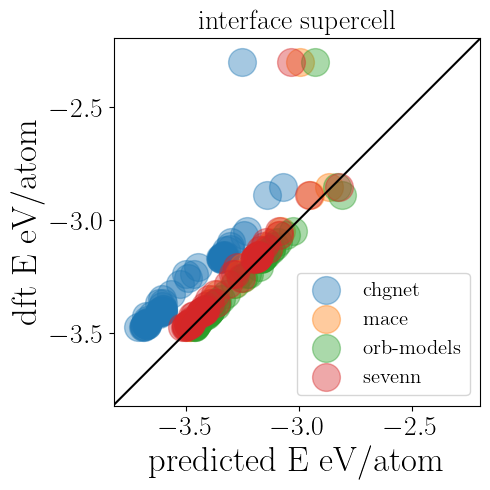

In [156]:
draw('sup_Es', 'interface supercell')

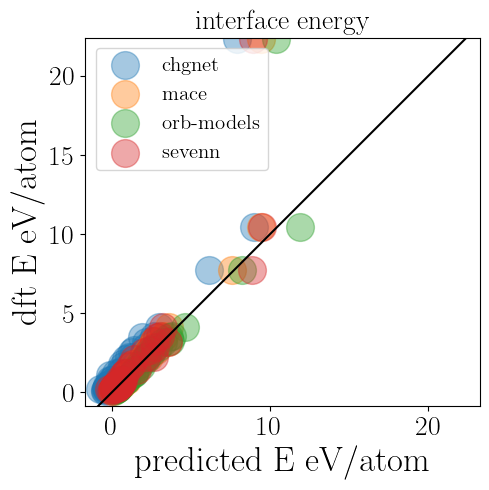

In [157]:
draw('it_Es', 'interface energy')

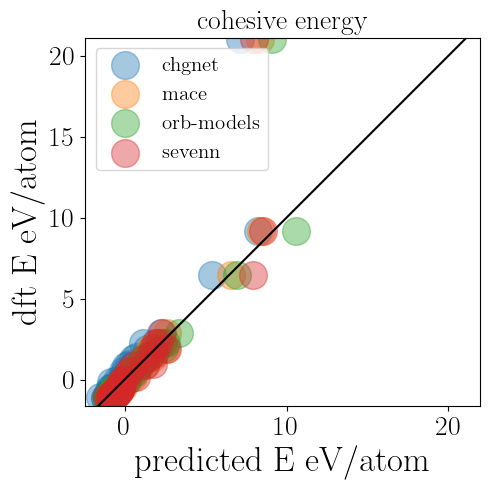

In [158]:
draw('bd_Es', 'cohesive energy')